In [13]:
import os
import pickle
from pathlib import Path
import pickle
import re
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import h5py
import scipy
from scipy import signal
from tqdm import tnrange
from tqdm import tqdm
import seaborn as sns

from scipy.stats import norm,entropy,linregress
from scipy.optimize import minimize, curve_fit
from scipy.io import savemat
from scipy.special import erf
from sklearn.linear_model import LogisticRegression
from joblib import Parallel, delayed

#import multiprocess as mp
#from multiprocess import Pool
import sys
import warnings

from odor_breathing_functions import*

from functions_beh import*
from data_loader import*
from hdf5_loader_and_aux_functions import*


warnings.filterwarnings('ignore')

cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']
modulename = 'multiprocess'
mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context('poster', font_scale=1.1)

In [8]:
all_data = load_hdf5("sessions_kyrell.h5")

In [9]:
cum_odor_all, _ = convert_pooled_to_array(all_data, "cum_odor", by_animal=False)
sniff_hist_all, _ = convert_pooled_to_array(all_data, "sniff_hist", by_animal=False)
sniff_hist_sh_all, _ = convert_pooled_to_array(all_data, "sniff_hist_shuffled", by_animal=False)
high_choices_all, _ = convert_pooled_to_array(all_data, "high_choices", by_animal=False)

selected_trials = np.logical_and(cum_odor_all>0,cum_odor_all<21).squeeze()
cum_odor_selected = cum_odor_all[selected_trials]
sniff_hist_selected = sniff_hist_all[selected_trials,:]
high_choices_selected = high_choices_all[selected_trials]
sniff_hist_sh_selected = sniff_hist_sh_all[selected_trials]

In [11]:
def bootstrap_worker(X, y, random_state=None):
    rng = np.random.default_rng(random_state)
    idx = rng.choice(len(y), len(y), replace=True)
    Xb, yb = X[idx], y[idx]

    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(Xb, yb)
    weights = model.coef_[0][:len(Xb)]/model.coef_[0][:len(Xb)].max()
    return weights.ravel()


def bs_logistic(
    X,
    y,
    N_bootstrap=15000,
    n_jobs=-1,
    random_seed=None,
):
    rng = np.random.default_rng(random_seed)
    seeds = rng.integers(0, 1e6, size=N_bootstrap)

    results = Parallel(n_jobs=n_jobs)(
        delayed(bootstrap_worker)(X, y, random_state=s)
        for s in seeds
    )

    all_coefs = np.vstack(results)
    mean_coefs = all_coefs.mean(axis=0)
    std_coefs = all_coefs.std(axis=0)
    ci_low = np.percentile(all_coefs, 2.5, axis=0)
    ci_high = np.percentile(all_coefs, 97.5, axis=0)

    return {
        'all_coefs': all_coefs,
        'mean': mean_coefs,
        'std_coefs': std_coefs,
        'ci_low': ci_low,
        'ci_high': ci_high,
    }

In [14]:
res = bs_logistic(sniff_hist_all, high_choices_all, N_bootstrap=15000)
res_sh = bs_logistic(sniff_hist_sh_all, high_choices_all, N_bootstrap=15000)

/Users/boero/opt/anaconda3/envs/all_behavior/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/boero/opt/anaconda3/envs/all_behavior/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/boero/opt/anaconda3/envs/all_behavior/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/boero/opt/anaconda3/envs/all_behavior/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataC

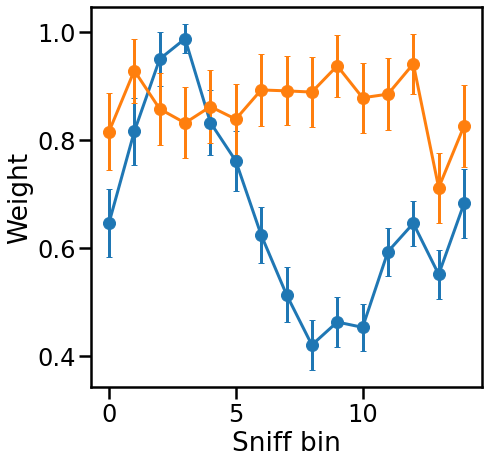

In [15]:
plt.figure(figsize=(7,7))
plt.errorbar(range(sniff_hist_all.shape[1]), res['mean'],
             yerr=res['std_coefs'],
             fmt='-o', capsize=3)
plt.errorbar(range(sniff_hist_sh_all.shape[1]), res_sh['mean'],
             yerr=res_sh['std_coefs'],
             fmt='-o', capsize=3)


plt.xlabel('Sniff bin')
plt.ylabel('Weight')
#plt.title('Bootstrapped Logistic Regression Weights')
plt.show()